# Get to Know LSTM

Long Short-Term Memory (LSTM) adalah salah satu jenis jaringan saraf dalam arsitektur Recurrent Neural Network (RNN) yang dirancang untuk memproses dan memprediksi data berurutan, seperti deret waktu (time series). Tidak seperti RNN biasa yang mudah melupakan informasi lama, LSTM dirancang dengan gates (input, forget, output) untuk mempertahankan informasi penting dalam jangka panjang. Hal ini sangat ideal untuk analisis harga saham yang memiliki pola historis dan musiman.

## Library yang Digunakan

pandas, numpy – untuk manipulasi dan analisis data.

matplotlib.pyplot – untuk visualisasi data.

tensorflow.keras – untuk membangun dan melatih model LSTM.

ruptures – untuk deteksi perubahan tren (trend shift).

sklearn.preprocessing.MinMaxScaler – untuk normalisasi data.

sklearn.metrics – untuk evaluasi model dengan metrik MAE, RMSE, MAPE.

In [70]:
import pandas as pd
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
import yfinance as yf
import numpy as np
import tensorflow as tf

### Deskripsi Dataset

Dataset yang digunakan dalam penelitian ini merupakan data harga saham Telkom Indonesia (TLKM) yang diambil dari Yahoo Finance. Data ini mencakup informasi harga saham harian mulai dari:

Tanggal awal: 28 September 2004

Tanggal akhir: 25 April 2025

Jumlah total data: 5.104 baris (hari perdagangan)

Dataset berisi beberapa kolom penting, antara lain:

Kolom	     Deskripsi
Date	     Tanggal perdagangan
Open	     Harga pembukaan saham pada hari tersebut
High	     Harga tertinggi saham pada hari tersebut
Low	         Harga terendah saham pada hari tersebut
Close	     Harga penutupan saham
Adj Close	 Harga penutupan yang telah disesuaikan dengan aksi korporasi (stock split, dividen)
Volume	     Jumlah saham yang diperdagangkan

Data ini bersifat time series dan digunakan untuk membangun model prediksi harga saham menggunakan metode deep learning LSTM.


### Pembersihan dan Persiapan Data || Interpolasi Nilai Kosong

Untuk mengatasi missing value, digunakan teknik Interpolasi, Interpolasi adalah teknik pengisian nilai kosong dengan memperkirakan nilai berdasarkan data di sekitarnya. Teknik ini penting dalam time series agar tren dan pola tidak terputus.


In [71]:
Y_df = pd.read_csv('Datasettelkom.csv')
Y_df = Y_df.reset_index(drop=True)
Y_df = Y_df.dropna()
Y_df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2025-04-25,2630,2650.0,2570.0,2600.0,2600.0,93439600.0
1,2025-04-24,2630,2650.0,2600.0,2630.0,2630.0,75733400.0
2,2025-04-23,2580,2640.0,2570.0,2630.0,2630.0,128704200.0
3,2025-04-22,2570,2570.0,2520.0,2550.0,2550.0,44958000.0
4,2025-04-21,2600,2610.0,2510.0,2570.0,2570.0,84209300.0


In [72]:
Y_df['Date'] = pd.to_datetime(Y_df['Date'])
Y_df = Y_df.sort_values('Date')
Y_df.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
5103,2004-09-28,835,835.0,825.0,825.0,399.35,90095000.0
5102,2004-09-29,825,825.0,810.0,825.0,399.35,29370000.0
5101,2004-09-30,825,830.0,825.0,830.0,401.77,42927500.0
5100,2004-10-01,830,845.0,825.0,840.0,406.61,108387500.0
5099,2004-10-04,845,880.0,845.0,870.0,421.13,424210000.0


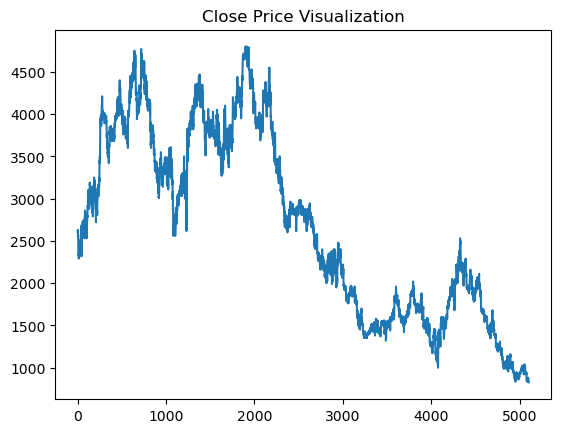

In [73]:
plt.title("Close Price Visualization")
plt.plot(Y_df.Close)

In [74]:
Y_df

,Date,Open,High,Low,Close,Adj_Close,Volume
5103,2004-09-28,835,835.0,825.0,825.0,399.35,90095000.0
5102,2004-09-29,825,825.0,810.0,825.0,399.35,29370000.0
5101,2004-09-30,825,830.0,825.0,830.0,401.77,42927500.0
5100,2004-10-01,830,845.0,825.0,840.0,406.61,108387500.0
5099,2004-10-04,845,880.0,845.0,870.0,421.13,424210000.0
...,...,...,...,...,...,...,...
4,2025-04-21,2600,2610.0,2510.0,2570.0,2570.00,84209300.0
3,2025-04-22,2570,2570.0,2520.0,2550.0,2550.00,44958000.0
2,2025-04-23,2580,2640.0,2570.0,2630.0,2630.00,128704200.0
1,2025-04-24,2630,2650.0,2600.0,2630.0,2630.00,75733400.0


In [76]:
for col in Y_df.select_dtypes(include='object').columns:
    Y_df[col] = pd.to_numeric(Y_df[col], errors='coerce')

In [77]:
Y_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5104 entries, 5103 to 0
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5104 non-null   datetime64[ns]
 1   Open       5076 non-null   float64       
 2   High       5104 non-null   float64       
 3   Low        5104 non-null   float64       
 4   Close      5104 non-null   float64       
 5   Adj_Close  5104 non-null   float64       
 6   Volume     5104 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 319.0 KB


### Visualisasi dan Moving Average

Harga penutupan divisualisasikan dan dihitung rata-rata bergerak 100 hari dan 200 hari untuk melihat tren jangka menengah dan panjang.

In [78]:
ma100 = Y_df.Close.rolling(100).mean()
ma100

5103       NaN
5102       NaN
5101       NaN
5100       NaN
5099       NaN
         ...  
4       2578.5
3       2577.1
2       2577.4
1       2577.9
0       2578.6
Name: Close, Length: 5104, dtype: float64

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

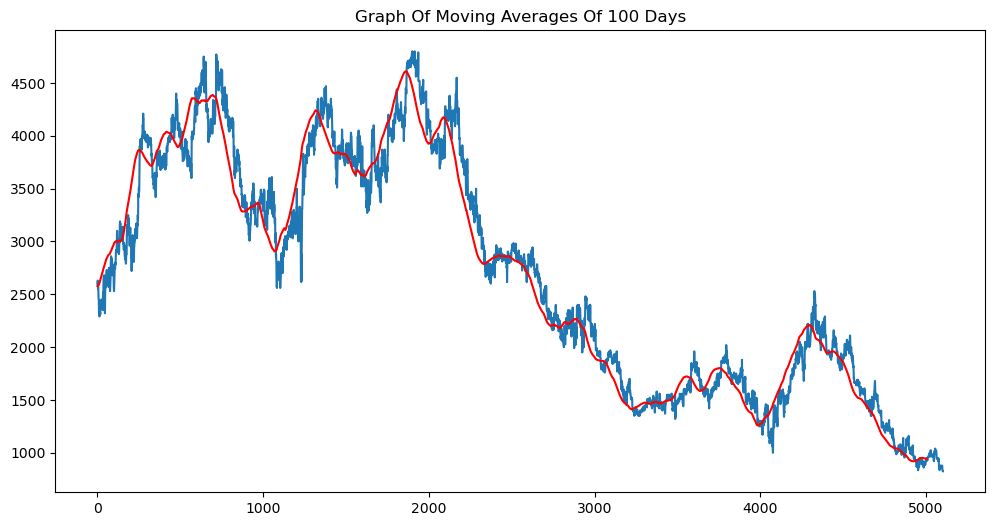

In [79]:
plt.figure(figsize = (12,6))
plt.plot(Y_df.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')

In [80]:
ma200 = Y_df.Close.rolling(200).mean()
ma200

5103        NaN
5102        NaN
5101        NaN
5100        NaN
5099        NaN
         ...   
4       2786.15
3       2784.15
2       2782.55
1       2780.75
0       2778.75
Name: Close, Length: 5104, dtype: float64

Text(0.5, 1.0, 'Comparision Of 100 Days And 200 Days Moving Averages')

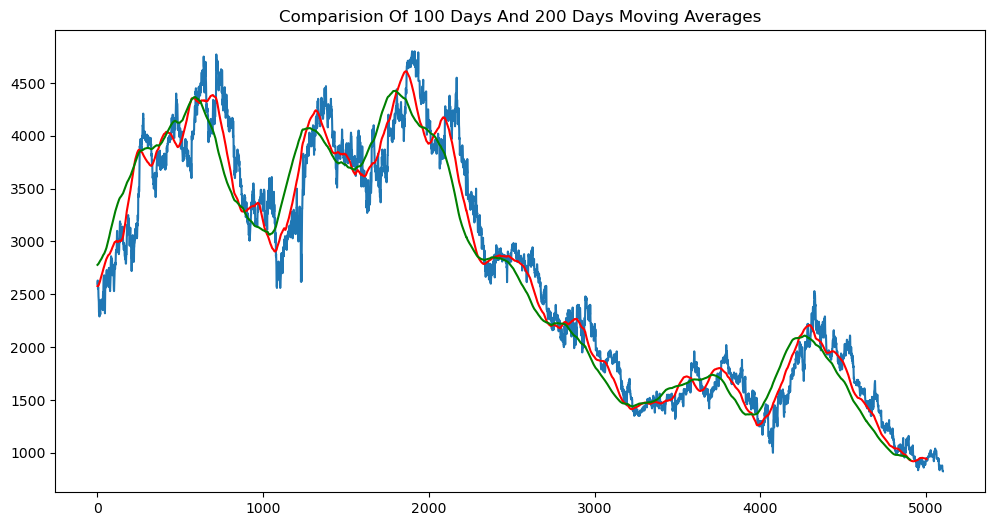

In [81]:
plt.figure(figsize = (12,6))
plt.plot(Y_df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')

In [82]:
Y_df.shape

(5104, 7)

# Trend Shift Detection

Menggunakan library ruptures, dilakukan deteksi titik perubahan tren harga saham menggunakan metode Binary Segmentation (Binseg).


In [83]:
!pip install ruptures --quiet

In [100]:
signal = Y_df['Close'].values.reshape(-1, 1)

In [99]:
# Deteksi Perubahan Tren
import ruptures as rpt
model = "l2"
algo = rpt.Binseg(model=model).fit(signal)
changes = algo.predict(n_bkps=4)

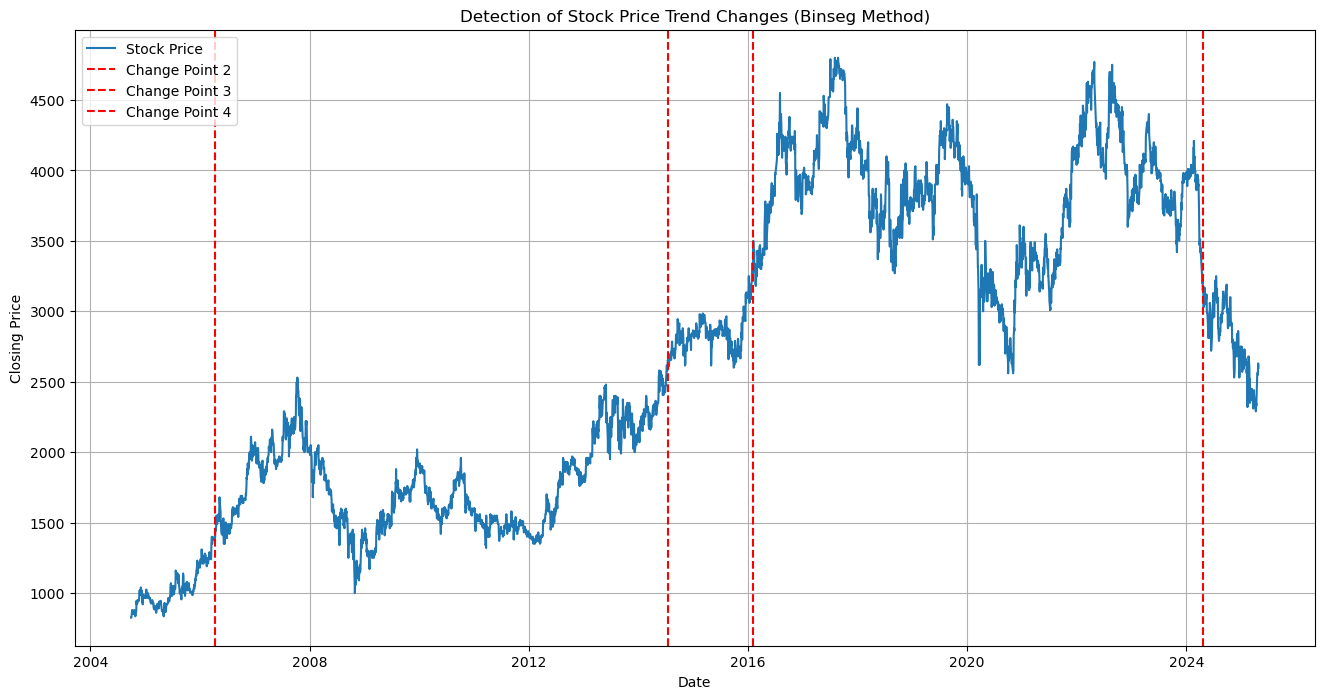

In [102]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.plot(Y_df['Date'], Y_df['Close'], label='Stock Price')

# Tambahkan garis vertikal untuk setiap titik perubahan
for i, change in enumerate(changes):
    if change < len(Y_df):
        label = f'Change Point {i+1}' if i != 0 else ''
        plt.axvline(Y_df['Date'].iloc[change], color='red', linestyle='--', label=label)

plt.title('Detection of Stock Price Trend Changes (Binseg Method)')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

# Spliting the dataset into training (70%) and testing (30%) set

Data dibagi menjadi 70% data pelatihan dan 30% data pengujian.

In [103]:
data = pd.read_csv('Datasettelkom.csv')
data = data.reset_index(drop=True)
data = data.dropna()
data.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2025-04-25,2630,2650.0,2570.0,2600.0,2600.0,93439600.0
1,2025-04-24,2630,2650.0,2600.0,2630.0,2630.0,75733400.0
2,2025-04-23,2580,2640.0,2570.0,2630.0,2630.0,128704200.0
3,2025-04-22,2570,2570.0,2520.0,2550.0,2550.0,44958000.0
4,2025-04-21,2600,2610.0,2510.0,2570.0,2570.0,84209300.0


In [104]:
# Splitting data into training and testing

train = pd.DataFrame(data[0:int(len(data)*0.70)])
test = pd.DataFrame(data[int(len(data)*0.70): int(len(data))])

print(train.shape)
print(test.shape)

(3572, 7)
(1532, 7)


In [105]:
train.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
0,2025-04-25,2630,2650.0,2570.0,2600.0,2600.0,93439600.0
1,2025-04-24,2630,2650.0,2600.0,2630.0,2630.0,75733400.0
2,2025-04-23,2580,2640.0,2570.0,2630.0,2630.0,128704200.0
3,2025-04-22,2570,2570.0,2520.0,2550.0,2550.0,44958000.0
4,2025-04-21,2600,2610.0,2510.0,2570.0,2570.0,84209300.0


In [106]:
test.head()

,Date,Open,High,Low,Close,Adj_Close,Volume
3572,2010-11-16,1630,1670.0,1620.0,1630.0,983.48,135845000.0
3573,2010-11-15,1640,1660.0,1610.0,1640.0,989.51,129820000.0
3574,2010-11-12,1650,1700.0,1640.0,1650.0,995.55,204247500.0
3575,2010-11-11,1700,1730.0,1680.0,1700.0,1025.72,248085000.0
3576,2010-11-10,1690,1700.0,1620.0,1690.0,1019.68,456532500.0


## Using MinMax scaler for normalization of the dataset

Menggunakan MinMaxScaler, data dinormalisasi ke rentang [0,1] agar cocok untuk pelatihan jaringan saraf.

In [107]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [108]:
train_close = train.iloc[:, 4:5].values
test_close = test.iloc[:, 4:5].values

In [109]:
data_training_array = scaler.fit_transform(train_close)
data_training_array

array([[0.36781609],
       [0.37643678],
       [0.37643678],
       ...,
       [0.10344828],
       [0.09770115],
       [0.10344828]])

### Persiapan Input Model
Input LSTM adalah deret waktu 100 hari sebelumnya untuk memprediksi hari ke-101.

In [110]:
x_train = []
y_train = [] 

for i in range(100, data_training_array.shape[0]):
    x_train.append(data_training_array[i-100: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [111]:
x_train.shape

(3472, 100, 1)

## ML Model (LSTM)

Model memiliki 4 lapisan LSTM berurutan dengan dropout (regularisasi), lalu diakhiri dengan lapisan Dense.

In [112]:
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential

In [113]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))


model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(units = 1))

C:\Users\MSI MODERN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [114]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 100, 50)             │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 100, 50)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 100, 60)             │          26,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 100, 60)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 100, 80)             │          45,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 100, 80)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 120)                 │          96,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 120)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             121 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [115]:
data_testing_array = scaler.fit_transform(test_close)
data_testing_array

array([[0.47214076],
       [0.47800587],
       [0.48387097],
       ...,
       [0.00293255],
       [0.        ],
       [0.        ]])

In [116]:
x_test = []
y_test = [] 

for i in range(100, data_testing_array.shape[0]):
    x_test.append(data_testing_array[i-100: i])
    y_test.append(data_testing_array[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test) 

In [117]:
x_test.shape

(1432, 100, 1)

### Pelatihan Model
Model dikompilasi dengan optimizer adam dan loss mean_squared_error, dilatih selama 15 epoch.

In [119]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['MAE'])
model.fit(x_train, y_train, validation_data = (x_test, y_test) ,epochs = 15)

Epoch 1/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 81s 494ms/step - MAE: 0.0868 - loss: 0.0137 - val_MAE: 0.0428 - val_loss: 0.0031
Epoch 2/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 52s 477ms/step - MAE: 0.0699 - loss: 0.0089 - val_MAE: 0.0475 - val_loss: 0.0038
Epoch 3/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 54s 495ms/step - MAE: 0.0663 - loss: 0.0079 - val_MAE: 0.0448 - val_loss: 0.0034
Epoch 4/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 81s 484ms/step - MAE: 0.0660 - loss: 0.0078 - val_MAE: 0.0404 - val_loss: 0.0027
Epoch 5/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 51s 465ms/step - MAE: 0.0597 - loss: 0.0065 - val_MAE: 0.0436 - val_loss: 0.0032
Epoch 6/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 54s 497ms/step - MAE: 0.0590 - loss: 0.0062 - val_MAE: 0.0392 - val_loss: 0.0027
Epoch 7/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 77s 446ms/step - MAE: 0.0575 - loss: 0.0058 - val_MAE: 0.0385 - val_loss: 0.0026
Epoch 8/15
109/109 ━━━━━━━━━━━━━━━━━━━━ 51s 465ms/step - MAE: 0.0555 - loss: 0.0055 - val_MAE: 0.0507 - val_loss: 0.0042
Epoch 9/15
109/109 ━━━━━━━━━━━━━

In [120]:
model.save('keras_model.h5')

In [121]:
test_close.shape
test_close

array([[1630.],
       [1640.],
       [1650.],
       ...,
       [ 830.],
       [ 825.],
       [ 825.]])

In [122]:
past_100_days = pd.DataFrame(train_close[-100:])
past_100_days

,0
0,1420.0
1,1420.0
2,1400.0
3,1420.0
4,1450.0
...,...
95,1630.0
96,1660.0
97,1680.0
98,1660.0


In [123]:
test_df = pd.DataFrame(test_close)

### Defining the final dataset for testing by including last 100 coloums of the training dataset to get the prediction from the 1st column of the testing dataset.

In [124]:
import pandas as pd

final_df = pd.concat([past_100_days, test_df], ignore_index=True)


In [125]:
final_df.head()

,0
0,1420.0
1,1420.0
2,1400.0
3,1420.0
4,1450.0


In [126]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.34897361],
       [0.34897361],
       [0.3372434 ],
       ...,
       [0.00293255],
       [0.        ],
       [0.        ]])

In [127]:
input_data.shape

(1632, 1)

### Testing the model

### Making prediction and plotting the graph of predicted vs actual values

In [128]:
# Making predictions

y_pred = model.predict(x_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 13s 223ms/step


In [130]:
y_pred.shape

(1432, 1)

In [131]:
y_test

array([0.44281525, 0.44281525, 0.46041056, ..., 0.00293255, 0.        ,
       0.        ])

In [132]:
y_pred

array([[0.4369818 ],
       [0.43806055],
       [0.4396793 ],
       ...,
       [0.0437279 ],
       [0.04321215],
       [0.04277229]], dtype=float32)

In [133]:
scaler.scale_

array([0.00058651])

In [134]:
scale_factor = 1/0.00985902
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

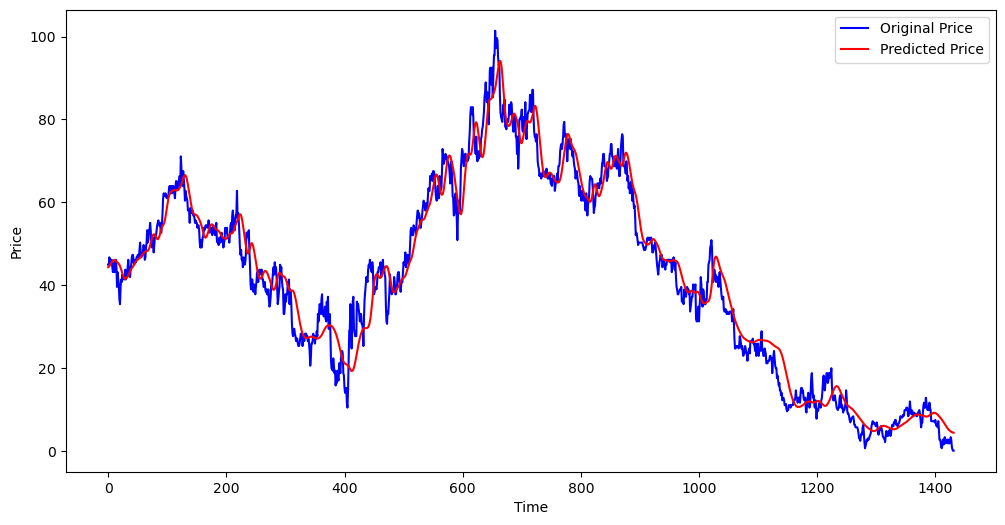

In [135]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Original Price")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Model evaluation || Prediksi pada data uji dibandingkan dengan nilai aktual.

### 1️⃣ MAE (Mean Absolute Error)

💡 Definisi:
MAE adalah rata-rata dari selisih absolut antara nilai aktual dan nilai prediksi.

MAE=Rp3.543,85


🗣️ Artinya:
Model, rata-rata, melakukan kesalahan sebesar Rp 3.543 per hari dalam memprediksi harga saham Telkom. Ini menunjukkan tingkat kesalahan yang cukup rendah, mengingat harga saham berada pada kisaran ribuan rupiah.

In [138]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
print("Mean absolute error on test set: ", mae)

Mean absolute error on test set:  3.5438517630982402


# Prediksi 24 Bulan ke Depan

Setelah model dilatih, digunakan untuk membuat prediksi 24 bulan ke depan dengan strategi recursive forecasting (menggunakan hasil prediksi sebelumnya sebagai input baru).

In [142]:
future_predictions = []
input_seq = train_close[-100:]  # ambil 100 data terakhir dari dataset historis
input_seq = scaler.transform(input_seq)  # normalisasi

# Ubah ke format input LSTM
input_seq = list(input_seq)

for _ in range(24):  # 24 bulan ke depan
    x_input = np.array(input_seq[-100:])  # ambil 100 terakhir
    x_input = x_input.reshape(1, 100, 1)  # format input LSTM
    pred = model.predict(x_input, verbose=0)
    
    input_seq.append(pred[0])  # tambahkan hasil prediksi ke input berikutnya
    future_predictions.append(pred[0])  # simpan hasil prediksi

# Denormalisasi hasil prediksi
future_predictions = np.array(future_predictions)
future_predictions = scaler.inverse_transform(future_predictions)


### Visualisasi Hasil Prediksi

Prediksi harga saham ditampilkan bersama tren historis. Prediksi menunjukkan kecenderungan stabil/naik dalam dua tahun ke depan.

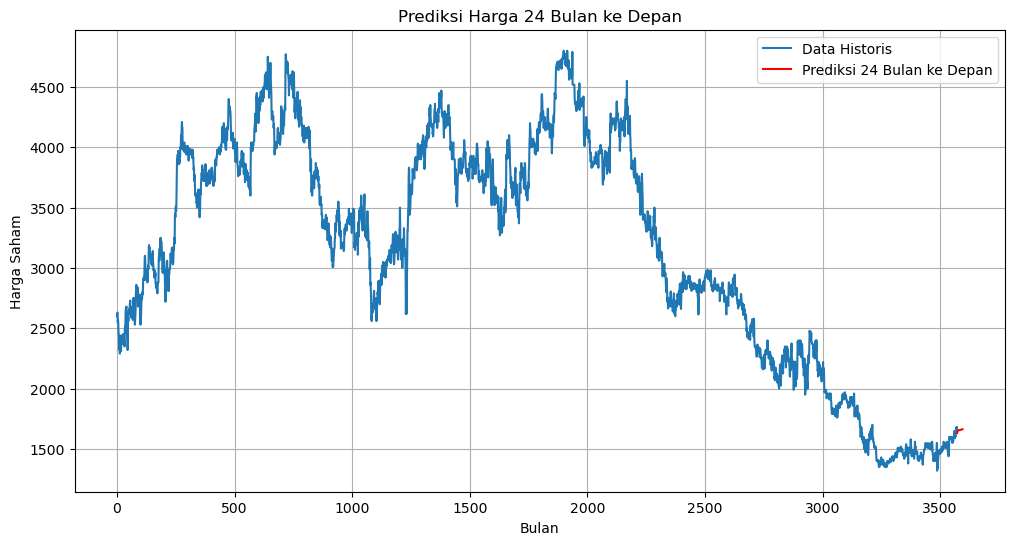

In [143]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(np.arange(len(train_close)), scaler.inverse_transform(scaler.transform(train_close)), label='Data Historis')
plt.plot(np.arange(len(train_close), len(train_close)+24), future_predictions, color='red', label='Prediksi 24 Bulan ke Depan')

plt.title("Prediksi Harga 24 Bulan ke Depan")
plt.xlabel("Bulan")
plt.ylabel("Harga Saham")
plt.legend()
plt.grid(True)
plt.show()


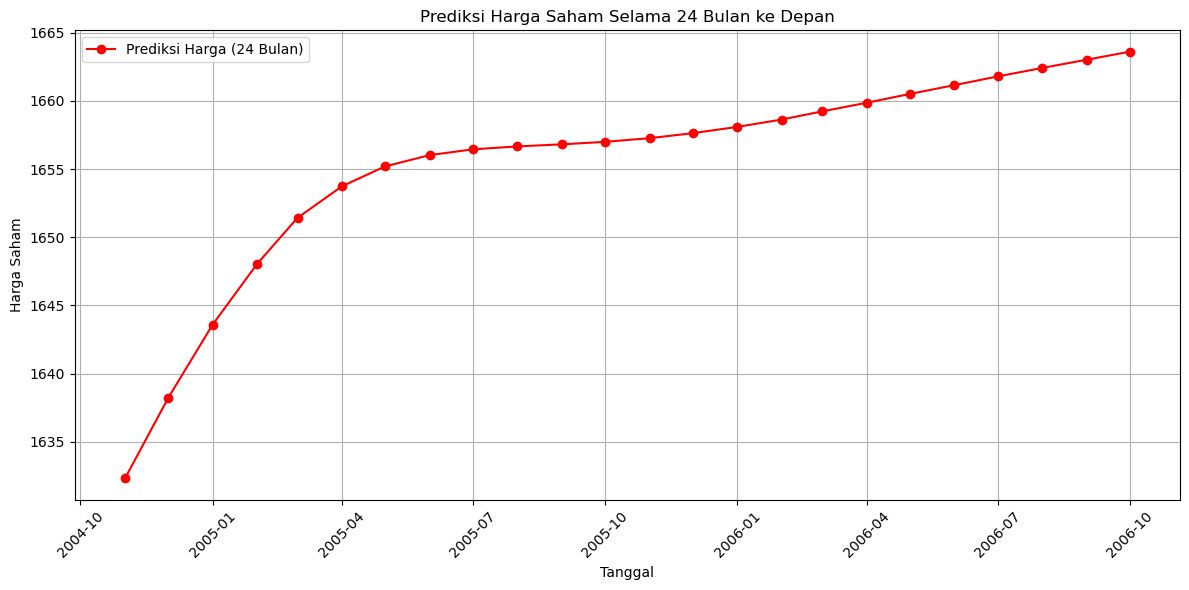

In [144]:
import matplotlib.pyplot as plt

# Buat index waktu untuk prediksi (misal bulanan)
# Misalnya tanggal terakhir di dataset: 2023-12-01
# Ganti sesuai tanggal aktual dataset kamu
last_date = pd.to_datetime(data['Date'].iloc[-1])
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=24, freq='MS')

# Masukkan ke DataFrame prediksi
future_df = pd.DataFrame({
    'Date': future_dates,
    'Predicted Price': future_predictions.flatten()
})

# Visualisasi prediksi 24 bulan saja
plt.figure(figsize=(12,6))
plt.plot(future_df['Date'], future_df['Predicted Price'], marker='o', color='red', label='Prediksi Harga (24 Bulan)')
plt.title('Prediksi Harga Saham Selama 24 Bulan ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [149]:
for col in data.select_dtypes(include='object').columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

In [150]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5104 entries, 0 to 5103
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5104 non-null   datetime64[ns]
 1   Open       5076 non-null   float64       
 2   High       5104 non-null   float64       
 3   Low        5104 non-null   float64       
 4   Close      5104 non-null   float64       
 5   Adj_Close  5104 non-null   float64       
 6   Volume     5104 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 279.3 KB


In [152]:
# Konversi kolom 'Date' ke datetime dan set sebagai index
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')

# Resample ke bulanan
mf_monthly = data.resample('M').mean()

# Scaling kolom Close
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(mf_monthly[['Close']])


In [153]:
# Prediksi 24 bulan ke depan
n_future = 24
forecast_input = scaled_data[-100:]
forecast = []

for _ in range(n_future):
    input_pred = forecast_input[-100:].reshape(1, 100, 1)
    pred = model.predict(input_pred, verbose=0)
    forecast.append(pred[0, 0])
    forecast_input = np.append(forecast_input, pred, axis=0)

forecast = np.array(forecast).reshape(-1, 1)
forecast_actual = scaler.inverse_transform(forecast)

# Interpretasi data prediksi

### 1. Pola Umum Pergerakan Harga
Harga saham cenderung menurun dari Mei 2025 (Rp 2.955) hingga sekitar November 2025 (Rp 2.741).

Setelah mencapai titik rendah tersebut, harga saham mulai bergerak naik secara perlahan namun stabil hingga mencapai sekitar Rp 2.803 pada April 2027.

Ini menunjukkan pola penurunan jangka pendek, diikuti oleh pemulihan bertahap dalam jangka menengah hingga panjang.

###  2. Interpretasi Bulanan: Dinamika Harga
Periode	Pergerakan Harga Penutupan (Close)	Interpretasi

Mei – Nov 2025	Turun dari Rp 2.955 → Rp 2.741	Koreksi harga; mungkin mencerminkan tekanan pasar atau penyesuaian

Des 2025 – Apr 2026	Naik perlahan dari Rp 2.746 → Rp 2.784	Awal pemulihan; pasar mulai stabil kembali

Mei 2026 – Apr 2027	Stabil & meningkat tipis hingga Rp 2.803	Pergerakan sideways dengan tren optimis

In [155]:
# Siapkan tanggal untuk 24 bulan ke depan
last_date = mf_monthly.index[-1]
forecast_dates = pd.date_range(last_date + pd.offsets.MonthBegin(1), periods=n_future, freq='MS')

# Buat DataFrame hasil prediksi
forecast_df = pd.DataFrame(index=forecast_dates)
forecast_df['Close'] = forecast_actual.flatten()
forecast_df['Open'] = forecast_df['Close'] * 0.98  # Asumsi Open = 98% Close (jika tidak tersedia model lain)
forecast_df


,Close,Open
2025-05-01,2955.064453,2895.963135
2025-06-01,2889.514648,2831.724365
2025-07-01,2833.656006,2776.982910
2025-08-01,2790.283936,2734.478271
2025-09-01,2761.220947,2705.996582
2025-10-01,2745.926025,2691.007568
2025-11-01,2741.953857,2687.114746
2025-12-01,2746.025879,2691.105469
2026-01-01,2754.747314,2699.652344
2026-02-01,2765.213623,2709.909424


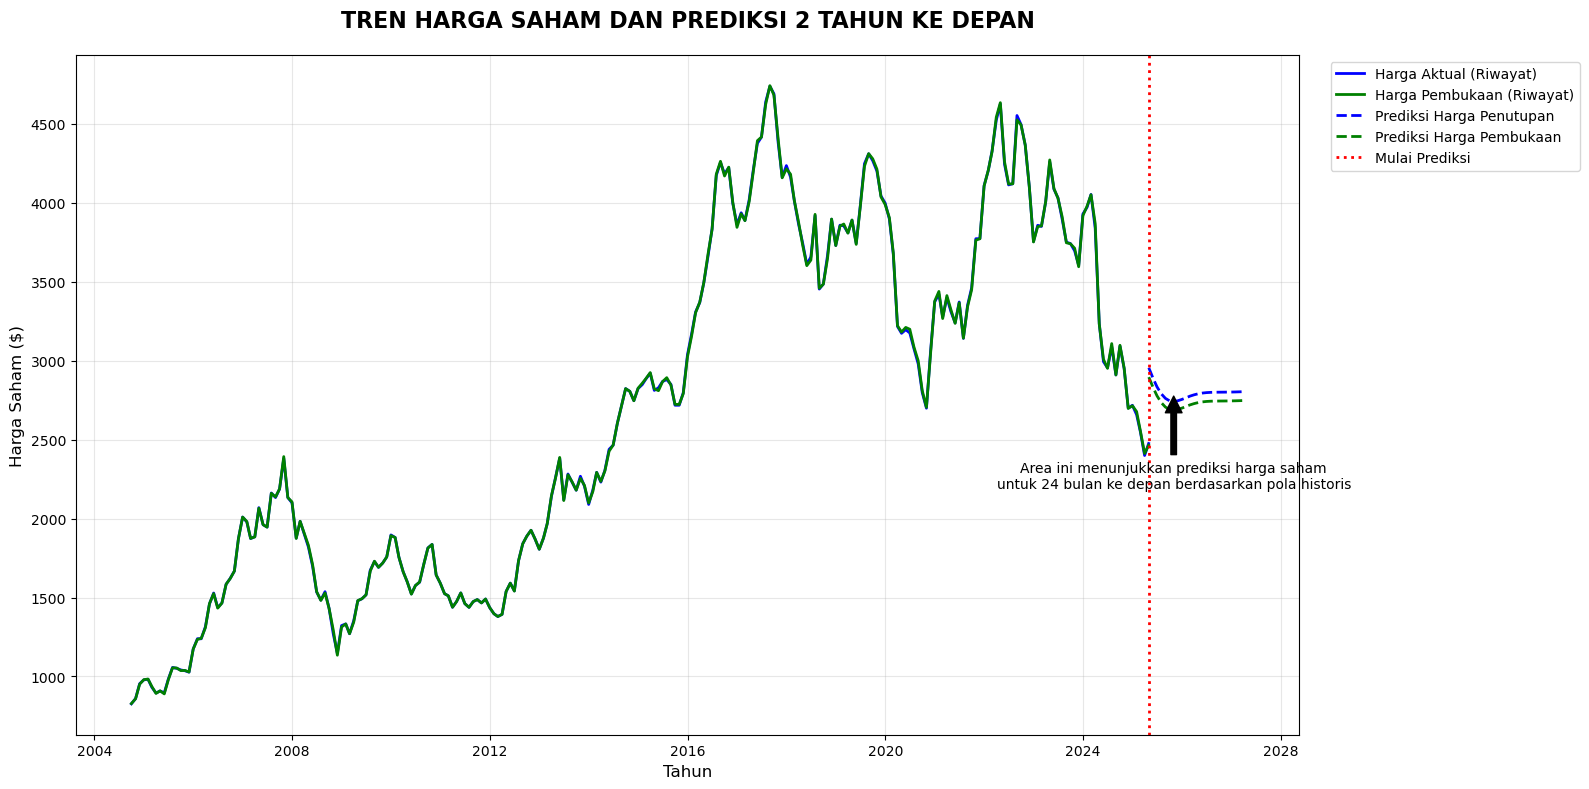

In [156]:
# Plot hasil
plt.figure(figsize=(16, 8))

# Plot riwayat
plt.plot(mf_monthly.index, mf_monthly['Close'], 'b-', linewidth=2, label='Harga Aktual (Riwayat)')
plt.plot(mf_monthly.index, mf_monthly['Open'], 'g-', linewidth=2, label='Harga Pembukaan (Riwayat)')

# Plot prediksi
plt.plot(forecast_df.index, forecast_df['Close'], 'b--', linewidth=2, label='Prediksi Harga Penutupan')
plt.plot(forecast_df.index, forecast_df['Open'], 'g--', linewidth=2, label='Prediksi Harga Pembukaan')

# Garis vertikal batas prediksi
plt.axvline(x=mf_monthly.index[-1], color='red', linestyle=':', linewidth=2, label='Mulai Prediksi')

plt.title('TREN HARGA SAHAM DAN PREDIKSI 2 TAHUN KE DEPAN', pad=20, fontsize=16, fontweight='bold')
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Harga Saham ($)', fontsize=12)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
plt.grid(True, alpha=0.3)

# Anotasi
plt.annotate(
    'Area ini menunjukkan prediksi harga saham\nuntuk 24 bulan ke depan berdasarkan pola historis',
    xy=(forecast_df.index[6], forecast_df['Close'].mean()),
    xytext=(forecast_df.index[6], forecast_df['Close'].min()*0.8),
    arrowprops=dict(facecolor='black', shrink=0.05),
    ha='center'
)

plt.tight_layout()
plt.show()


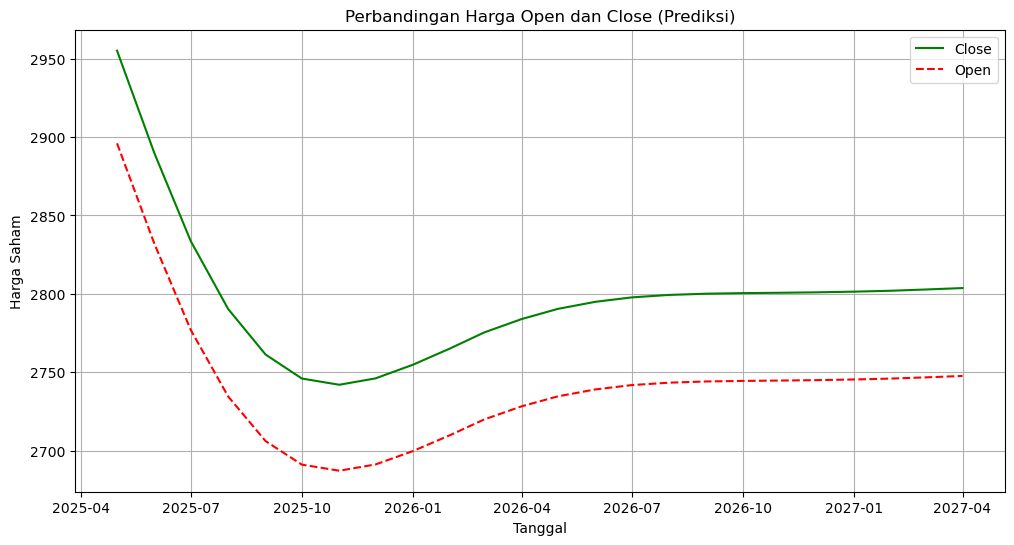

In [158]:
# Plot perbandingan Open dan Close
plt.figure(figsize=(12, 6))
plt.plot(forecast_df.index, forecast_df['Close'], label='Close', color='green')
plt.plot(forecast_df.index, forecast_df['Open'], label='Open', color='red', linestyle='--')
plt.title('Perbandingan Harga Open dan Close (Prediksi)')
plt.xlabel('Tanggal')
plt.ylabel('Harga Saham')
plt.legend()
plt.grid(True)
plt.show()



=== RINGKASAN PREDIKSI PER TAHUN ===


,Rata-rata,Minimum,Maksimum
Year,,,
2025,"2,807.96","2,741.95","2,955.06"
2026,"2,788.62","2,754.75","2,800.93"
2027,"2,802.41","2,801.34","2,803.64"


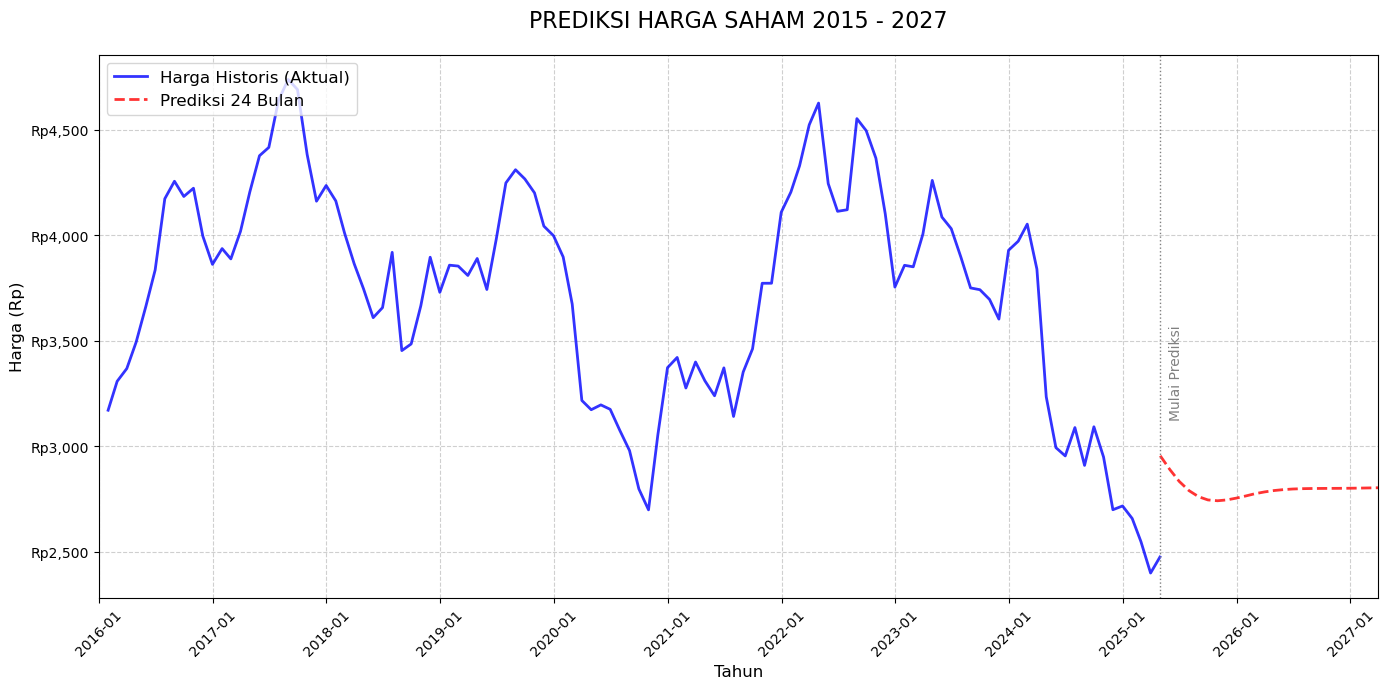

In [164]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# 1. Filter data dari tahun 2015
start_date = '2016-01-01'
historical = mf_monthly[['Close']].loc[start_date:]
forecast_df['Type'] = 'Prediksi'
historical['Type'] = 'Aktual'

# 2. Buat visualisasi utama
plt.figure(figsize=(14, 7))

# Plot data historis
plt.plot(historical.index, historical['Close'], 
         'b-', linewidth=2, label='Harga Historis (Aktual)', alpha=0.8)

# Plot prediksi
plt.plot(forecast_df.index, forecast_df['Close'], 
         'r--', linewidth=2, label='Prediksi 24 Bulan', alpha=0.8)

# Garis transisi antara data aktual dan prediksi
transition_date = historical.index[-1]
plt.axvline(x=transition_date, color='gray', linestyle=':', linewidth=1)
plt.text(transition_date + pd.DateOffset(months=1), 
         historical['Close'].mean()*0.9, 
         'Mulai Prediksi', 
         rotation=90, va='center', color='gray')

# 3. Format tampilan
plt.title('PREDIKSI HARGA SAHAM 2015 - {}'.format(forecast_df.index[-1].year), 
          fontsize=16, pad=20)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Harga (Rp)', fontsize=12)

# Format sumbu x untuk tampilan tahun-bulan
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

# Format sumbu y dalam format mata uang
def format_rp(x, pos):
    return f'Rp{x:,.0f}'
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_rp))

# 4. Tambahkan informasi tambahan
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=12, loc='upper left')

# Atur batas tanggal
plt.xlim([pd.to_datetime(start_date), forecast_df.index[-1]])

# Rotasi label tanggal
plt.xticks(rotation=45)

# 5. Tampilkan tabel prediksi per tahun
print("\n=== RINGKASAN PREDIKSI PER TAHUN ===")
forecast_df['Year'] = forecast_df.index.year
yearly_forecast = forecast_df.groupby('Year')['Close'].agg(['mean', 'min', 'max'])
yearly_forecast.columns = ['Rata-rata', 'Minimum', 'Maksimum']
display(yearly_forecast.style.format("{:,.2f}"))

plt.tight_layout()
plt.show()

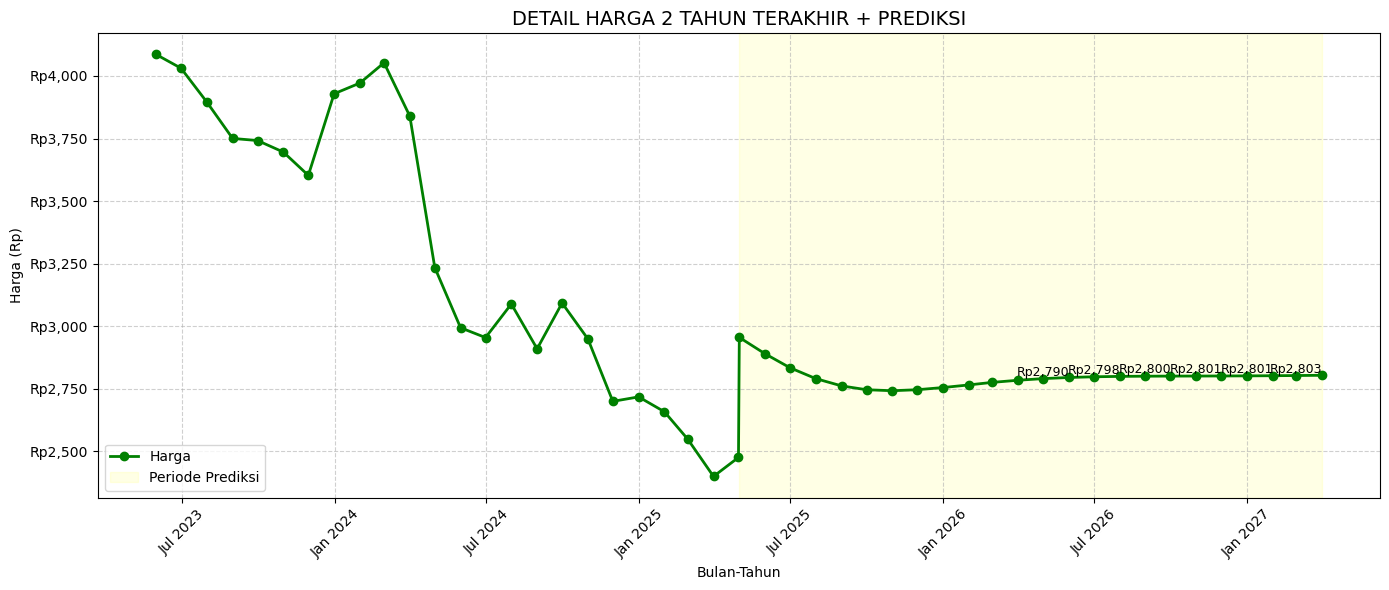

In [165]:
# Filter data untuk 2 tahun terakhir + prediksi
recent_and_forecast = pd.concat([
    historical.iloc[-24:],  # 2 tahun terakhir
    forecast_df[['Close']]
])

# Buat visualisasi detail
plt.figure(figsize=(14, 6))
plt.plot(recent_and_forecast.index, recent_and_forecast['Close'], 
         'g-', linewidth=2, marker='o', label='Harga')

# Highlight area prediksi
pred_start = forecast_df.index[0]
plt.axvspan(pred_start, forecast_df.index[-1], color='yellow', alpha=0.1, label='Periode Prediksi')

# Tambahkan label harga
for i, (date, price) in enumerate(zip(recent_and_forecast.index[-12:], recent_and_forecast['Close'][-12:])):
    if i % 2 == 0:  # Label setiap 2 bulan agar tidak terlalu padat
        plt.text(date, price, f'Rp{price:,.0f}', 
                 ha='center', va='bottom', fontsize=9)

plt.title('DETAIL HARGA 2 TAHUN TERAKHIR + PREDIKSI', fontsize=14)
plt.xlabel('Bulan-Tahun', fontsize=10)
plt.ylabel('Harga (Rp)', fontsize=10)
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_rp))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


=== DETAIL EVALUASI MODEL ===


,Nilai,Interpretasi
Metrik,,
Mean Absolute Error (MAE),Rp3.54,Rata-rata selisih mutlak prediksi dengan aktual
Root Mean Squared Error (RMSE),Rp4.63,Error prediksi dengan penekanan pada error besar
Mean Absolute Percentage Error (MAPE),nan%,Persentase error relatif terhadap harga aktual


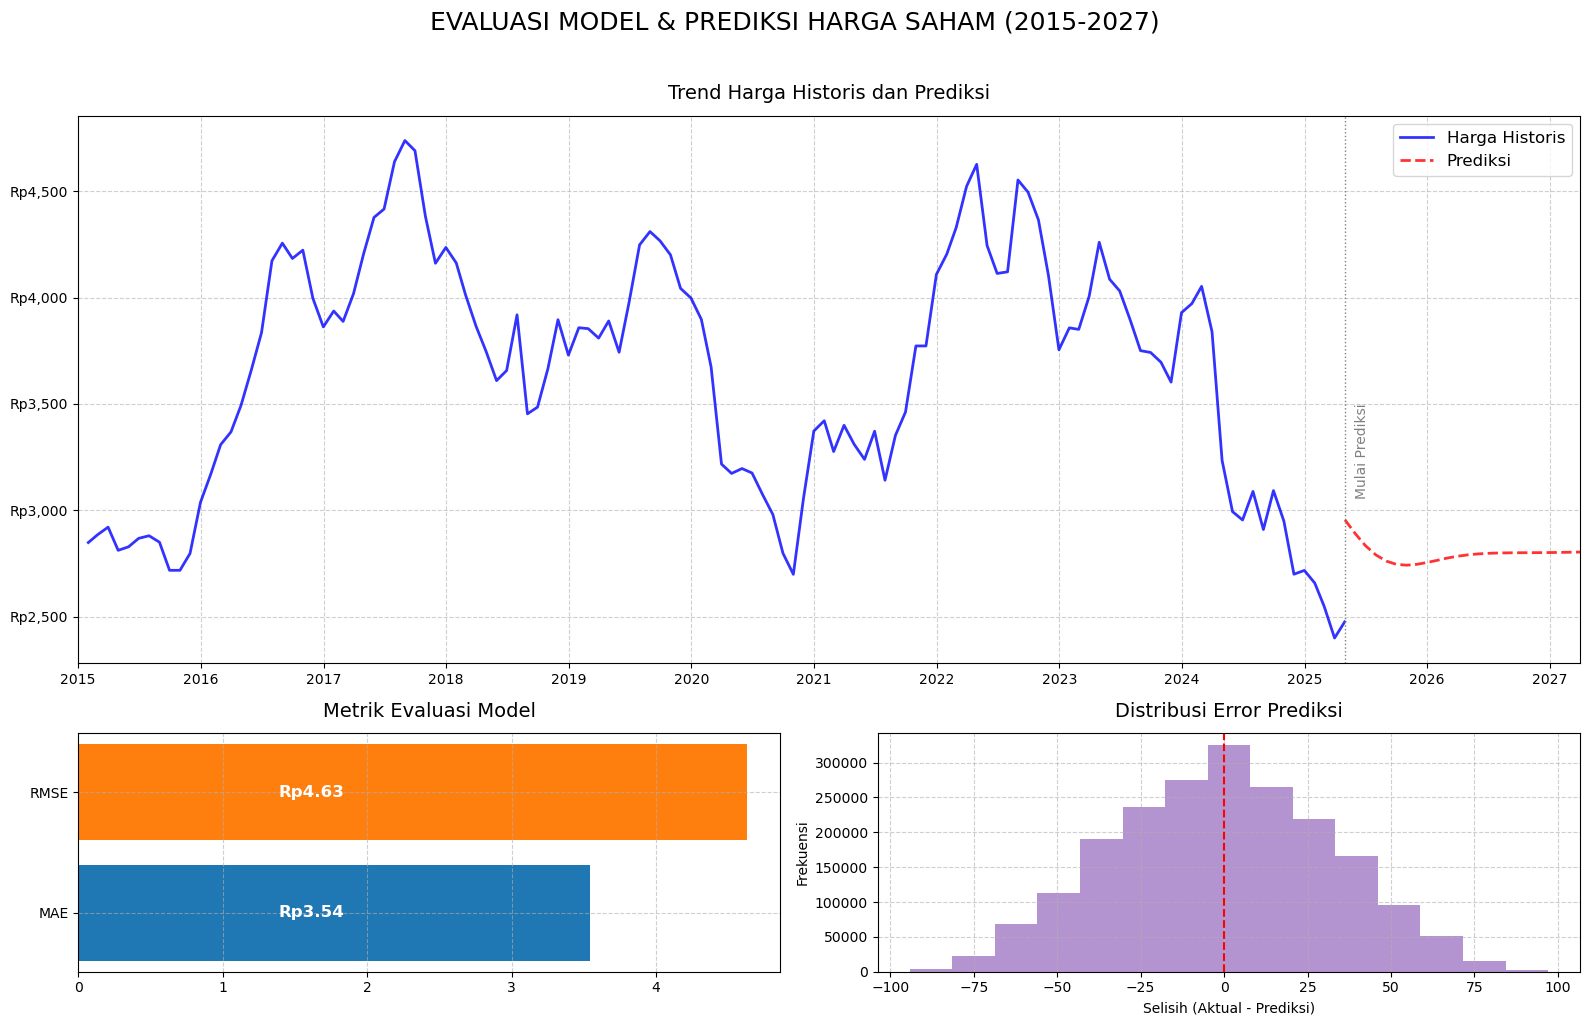

In [167]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd

# 1. Filter data from 2015
start_date = '2015-01-01'
historical = mf_monthly[['Close']].loc[start_date:]
forecast_df['Type'] = 'Prediksi'
historical['Type'] = 'Aktual'

# 2. Calculate evaluation metrics (example for test data)
# Assuming y_test (actual) and y_pred (predicted) from previous process
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Avoid division by zero for MAPE calculation
mape = np.mean(np.abs((y_test - y_pred) / np.where(y_test != 0, y_test, np.nan))) * 100

# 3. Create main visualization
plt.figure(figsize=(16, 10))
plt.suptitle('EVALUASI MODEL & PREDIKSI HARGA SAHAM (2015-{})'.format(forecast_df.index[-1].year), 
             fontsize=18, y=1.02)

# Subplot 1: Main plot
ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2, rowspan=2)
ax1.plot(historical.index, historical['Close'], 'b-', linewidth=2, label='Harga Historis', alpha=0.8)
ax1.plot(forecast_df.index, forecast_df['Close'], 'r--', linewidth=2, label='Prediksi', alpha=0.8)
ax1.axvline(x=historical.index[-1], color='gray', linestyle=':', linewidth=1)
ax1.text(historical.index[-1] + pd.DateOffset(months=1), historical['Close'].mean()*0.9, 
        'Mulai Prediksi', rotation=90, va='center', color='gray')

# Format subplot 1
ax1.set_title('Trend Harga Historis dan Prediksi', fontsize=14, pad=12)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'Rp{x:,.0f}'))
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend(fontsize=12)
ax1.set_xlim([pd.to_datetime(start_date), forecast_df.index[-1]])

# Subplot 2: Model Evaluation
ax2 = plt.subplot2grid((3, 2), (2, 0))
metrics = {
    'MAE': f'Rp{mae:,.2f}',
    'RMSE': f'Rp{rmse:,.2f}',
    'MAPE': f'{mape:.2f}%'
}
ax2.barh(list(metrics.keys()), [mae, rmse, mape], color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax2.set_title('Metrik Evaluasi Model', fontsize=14, pad=12)
ax2.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}' if x < 100 else f'{x:,.0f}%'))
ax2.grid(True, linestyle='--', alpha=0.6)

# Add value labels on bars
for i, (k, v) in enumerate(metrics.items()):
    ax2.text(mape*0.3 if i == 2 else max(mae, rmse)*0.3, i, v, 
             ha='left', va='center', fontsize=12, color='white', fontweight='bold')

# Subplot 3: Error Distribution
ax3 = plt.subplot2grid((3, 2), (2, 1))
errors = y_test - y_pred

# Filter out NaN or infinite values for the histogram
errors = errors[np.isfinite(errors)]
ax3.hist(errors, bins=15, color='#9467bd', alpha=0.7)
ax3.axvline(x=0, color='red', linestyle='--')
ax3.set_title('Distribusi Error Prediksi', fontsize=14, pad=12)
ax3.set_xlabel('Selisih (Aktual - Prediksi)')
ax3.set_ylabel('Frekuensi')
ax3.grid(True, linestyle='--', alpha=0.6)

# 4. Display evaluation table
print("\n=== DETAIL EVALUASI MODEL ===")
eval_table = pd.DataFrame({
    'Metrik': ['Mean Absolute Error (MAE)', 'Root Mean Squared Error (RMSE)', 
               'Mean Absolute Percentage Error (MAPE)'],
    'Nilai': [f'Rp{mae:,.2f}', f'Rp{rmse:,.2f}', f'{mape:.2f}%'],
    'Interpretasi': [
        'Rata-rata selisih mutlak prediksi dengan aktual',
        'Error prediksi dengan penekanan pada error besar',
        'Persentase error relatif terhadap harga aktual'
    ]
}).set_index('Metrik')

display(eval_table.style.set_properties(**{
    'background-color': '#f8f9fa',
    'border': '1px solid #ddd'
}))

plt.tight_layout()
plt.show()
